# KANs & MLPs accurancies

Paragoniamo ora l'accuratezza delle MLP e delle KAN mostrando come variano le loss function di test (RMSE) dei suddetti modelli in funzione del numero di parametri allenabili, considerando MLP di diversa profondità. In particolare studiamo due casi differenti con funzioni da fittare di complessità crescente, di cui la seconda fittabile attraverso una deep layer KAN: ciò ci darà un quadro generale sull'accuratezza dei modelli MLP e KAN per la risoluzione dei problemi di regressione.

---

## Caso 1

Prima di tutto consideriamo di voler fittare una funzione a due variabili abbastanza semplice, ma senza una "compositional structure":
\begin{equation}
f(x,y) = \frac{x^2}{y^2+1}\,\,\,,
\end{equation}
che sappiamo che può essere fittata da una KAN avente parametri $[2,5,1]$, avendo due input $x$ e $y$.

In seguito tenteremo di fittare una funzione più complessa, così da introdurre anche le deep leyer KAN.

---

In [1]:
from kan import *
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

torch.set_num_threads(1)

In [2]:
# Impostazione dei semi per la riproducibilità
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Cominciamo generando il dataset.

In [3]:
# Costruisco il dataset
x_train = np.random.uniform(-1, 1, 3000)
y_train = np.random.uniform(-1, 1, 3000)
training_label = (x_train**2)/(y_train**2 + 1)

x_test = np.random.uniform(-1, 1, 200)
y_test = np.random.uniform(-1, 1, 200)
test_label = (x_test**2)/(y_test**2 + 1)

# Combino x_train e y_train in un singolo array
training_data = np.column_stack((x_train, y_train))
test_data = np.column_stack((x_test, y_test))

# Converto i dati in tensori PyTorch
training_data = torch.tensor(training_data, dtype=torch.float32)
training_label = torch.tensor(training_label, dtype=torch.float32).view(-1, 1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32).view(-1, 1)

# Definisco il dizionario necessario per il training della KAN
dataset = {
    'train_input': training_data,
    'train_label': training_label,
    'test_input': test_data,
    'test_label': test_label
}

Fittiamo quindi la funzione $f(x,y)$ utilizzando diverse MLP, aventi diversa profonidtà e ampiezza, e plottando la loss di test finale a cui arriva l'addestramento in funzione del numero di parametri della rete.

In particolare, ogni MLP di diversa profondità sarà determinata da una "curva di apprendimento", che ci aspettiamo decresca come $P^{-m}$, dove $P$ è il numero di parametri della rete.

Paragoneremo queste curve di apprendimento alla curva di apprendimento della KAN precedente, a cui andremo ad aggiungere parametri solamente aumentando il numero di grid $G$. Ci aspettiamo che questa curva decresca come $P^{-k}$. Andremo quindi a paragonare l'andamento di tali curve in funzione del numero di parametri.

Definiamo quindi prima di tutto la classe che servirà a definire man mano le MLP.

In [4]:
# Definisco la classe MLP che serve a fittare la funzione f
class MLP(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, output_size=1):
        super(MLP, self).__init__()

        # Create a list to hold the layers
        layers = []

        # Add the first hidden layer, connected to the input layer
        layers.append(nn.Linear(input_size, hidden_layer_size))
        layers.append(nn.ReLU())

        # Add subsequent hidden layers, connected to each other
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_layer_size, hidden_layer_size))
            layers.append(nn.ReLU())

        # Add the output layer
        layers.append(nn.Linear(hidden_layer_size, output_size))

        # Combine the layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Definisco la classe MLP1 che servirà a fittare una funzione g più complessa
class MLP1(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, output_size=1):
        super(MLP1, self).__init__()

        # Create a list to hold the layers
        layers = []

        # Add the first hidden layer, connected to the input layer
        layers.append(nn.Linear(input_size, hidden_layer_size))
        layers.append(nn.Tanh())

        # Add subsequent hidden layers, connected to each other
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_layer_size, hidden_layer_size))
            layers.append(nn.ReLU())

        # Add the output layer
        layers.append(nn.Linear(hidden_layer_size, output_size))

        # Combine the layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Funzione che restituisce il numero di parametri allenabili di una NN
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
# Definisco l'input e le epoche
input_size = training_data.shape[1]
num_epochs = 1000

Alleno i modelli MLP con un singolo hidden layer.

In [6]:
set_seed(42)

mlp_parameters_d1 = []
mlp_test_loss_d1 = []

hidden_layers = 1
hidden_size = 2
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d1.append(final_test_loss)
mlp_parameters_d1.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 1
hidden_size = 4
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d1.append(final_test_loss)
mlp_parameters_d1.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 1
hidden_size = 8
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d1.append(final_test_loss)
mlp_parameters_d1.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 1
hidden_size = 16
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d1.append(final_test_loss)
mlp_parameters_d1.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

Loss function di test MLP(1,2): 0.2320
Loss function di test MLP(1,4): 0.1013
Loss function di test MLP(1,8): 0.0714
Loss function di test MLP(1,16): 0.0589


Alleno i modelli MLP con due hidden layer.

In [7]:
set_seed(42)

mlp_parameters_d2 = []
mlp_test_loss_d2 = []

hidden_layers = 2
hidden_size = 2
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d2.append(final_test_loss)
mlp_parameters_d2.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 2
hidden_size = 4
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d2.append(final_test_loss)
mlp_parameters_d2.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 2
hidden_size = 8
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d2.append(final_test_loss)
mlp_parameters_d2.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 2
hidden_size = 16
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d2.append(final_test_loss)
mlp_parameters_d2.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

Loss function di test MLP(2,2): 0.2234
Loss function di test MLP(2,4): 0.1163
Loss function di test MLP(2,8): 0.0258
Loss function di test MLP(2,16): 0.0144


Alleno i modelli MLP con tre hidden layer.

In [8]:
set_seed(42)

mlp_parameters_d3 = []
mlp_test_loss_d3 = []

hidden_layers = 3
hidden_size = 2
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d3.append(final_test_loss)
mlp_parameters_d3.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 3
hidden_size = 4
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d3.append(final_test_loss)
mlp_parameters_d3.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 3
hidden_size = 8
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d3.append(final_test_loss)
mlp_parameters_d3.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 3
hidden_size = 16
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d3.append(final_test_loss)
mlp_parameters_d3.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

Loss function di test MLP(3,2): 0.2042
Loss function di test MLP(3,4): 0.1073
Loss function di test MLP(3,8): 0.2367
Loss function di test MLP(3,16): 0.0077


Alleno i modelli MLP con quattro hidden layer.

In [9]:
set_seed(42)

mlp_parameters_d4 = []
mlp_test_loss_d4 = []

hidden_layers = 4
hidden_size = 2
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d4.append(final_test_loss)
mlp_parameters_d4.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 4
hidden_size = 4
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d4.append(final_test_loss)
mlp_parameters_d4.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 4
hidden_size = 8
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d4.append(final_test_loss)
mlp_parameters_d4.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 4
hidden_size = 16
mlp = MLP(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d4.append(final_test_loss)
mlp_parameters_d4.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

Loss function di test MLP(4,2): 0.2361
Loss function di test MLP(4,4): 0.0421
Loss function di test MLP(4,8): 0.0131
Loss function di test MLP(4,16): 0.0048


---

Definisco ora un modello KAN con architettura $[2,5,1]$,e lo alleno aumentando i grid man mano, in modo tale da aumentarne i parametri.

In [10]:
model = KAN(width=[2,5,1], grid=3, k=3, seed=0)

In [11]:
grids = [3,5,10,15,20]

kan_parameters = []
kan_test_loss = []

for i in range(len(grids)):
    model = KAN(width=[2,5,1], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
    kan_parameters.append(grids[i] * (4*2+2*1+1*1))
    kan_test_loss.append(results['test_loss'][-1].item())

train loss: 6.04e-04 | test loss: 6.20e-04 | reg: 1.23e+01 : 100%|██| 50/50 [00:16<00:00,  3.11it/s]
train loss: 2.92e-04 | test loss: 2.93e-04 | reg: 1.23e+01 : 100%|██| 50/50 [00:17<00:00,  2.93it/s]
train loss: 3.90e-05 | test loss: 3.93e-05 | reg: 1.23e+01 : 100%|██| 50/50 [00:20<00:00,  2.50it/s]
train loss: 1.29e-05 | test loss: 1.43e-05 | reg: 1.23e+01 : 100%|██| 50/50 [00:16<00:00,  3.04it/s]
train loss: 8.16e-06 | test loss: 1.03e-05 | reg: 1.23e+01 : 100%|██| 50/50 [00:18<00:00,  2.64it/s]


Possiamo ora plottare le curve di apprendimento delle MLP aventi diverse profondità e quella del modello KAN, allenata con diversi valori del grid $G$.

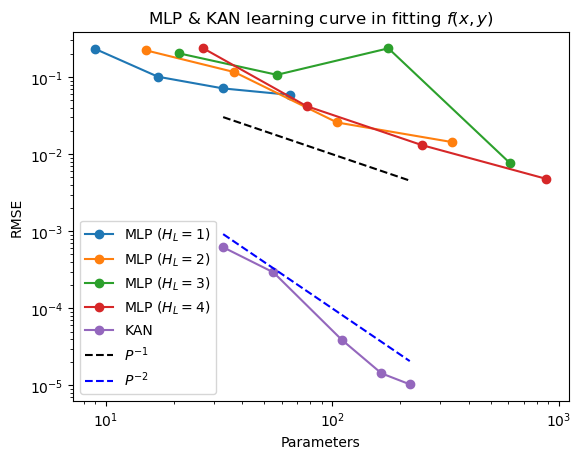

In [12]:
x = np.array(kan_parameters, dtype=float)
y = x**(-1)
z = np.array(kan_parameters, dtype=float)
t = z**(-2)

plt.figure()
plt.plot(mlp_parameters_d1, mlp_test_loss_d1, marker='o', label='MLP ($H_L=1$)')
plt.plot(mlp_parameters_d2, mlp_test_loss_d2, marker='o', label='MLP ($H_L=2$)')
plt.plot(mlp_parameters_d3, mlp_test_loss_d3, marker='o', label='MLP ($H_L=3$)')
plt.plot(mlp_parameters_d4, mlp_test_loss_d4, marker='o', label='MLP ($H_L=4$)')
plt.plot(kan_parameters, kan_test_loss, marker='o', label='KAN')
plt.plot(x, y, color='black', ls='--', label='$P^{-1}$')
plt.plot(z, t, color='blue', ls='--', label='$P^{-2}$')
plt.xlabel('Parameters')
plt.ylabel('RMSE')
plt.title('MLP & KAN learning curve in fitting $f(x,y)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Da questo grafico notiamo come la curva d'apprendimento delle MLP ha una pendenza minore rispetto a quella della KAN, infatti osserviamo che la RMSE delle MLP scala come $P^{-1}$, mentre la RMSE della KAN scala come $P^{-2}$. Inoltre osserviamo che a parità del numero di parametri allenabili, le KAN raggiungono un livello di accuratezza delle predizioni molto maggiore rispetto alle MLP, in quanto le RMSE differiscono di circa ben due ordini di grandezza.

---

## Caso 2

Abbiamo effettuato la nostra analisi su una funzione abbastanza semplice da fittare, cheper l'appunto poteva essere fittata attraverso una KAN standard, osservando che a parità del numero di parametri, il fitting mediante KAN surclassava quello mediante MLP.

Ora, vogliamo cercare di fittare una funzione più complicata, per determinare se in questo caso le MLP possono risultare più vantaggiose per un fitting, oppure se anche in questo caso le KAN hanno la supremazia.

Possiamo quindi riproporre l'analisi precedente con la funzione da fittare seguente:
\begin{equation}
g(x_1,x_2,x_3,x_4)=\exp\Big(\frac{1}{2}\big(\sin(\pi(x_1^2+x_2^2))+\sin(\pi(x_3^2+x_4^2))\big)\Big)\,\,\,.
\end{equation}

Secondo il teorema di rappresentazione di Kolmogorov-Arnold, è possibile rappresentare tale funzione attraverso una KAN standard con architettura $[4,9,1]$.

Generiamo quindi il dataset.

In [13]:
set_seed(42)

x1_train = np.random.uniform(-1, 1, 3000)
x2_train = np.random.uniform(-1, 1, 3000)
x3_train = np.random.uniform(-1, 1, 3000)
x4_train = np.random.uniform(-1, 1, 3000)
training_label = np.exp((np.sin(np.pi*(x1_train**2+x2_train**2))+np.sin(np.pi*(x3_train**2+x4_train**2)))/2)

x1_test = np.random.uniform(-1, 1, 200)
x2_test = np.random.uniform(-1, 1, 200)
x3_test = np.random.uniform(-1, 1, 200)
x4_test = np.random.uniform(-1, 1, 200)
test_label = np.exp((np.sin(np.pi*(x1_test**2+x2_test**2))+np.sin(np.pi*(x3_test**2+x4_test**2)))/2)

# Combino x_train e y_train in un singolo array
training_data = np.column_stack((x1_train, x2_train, x3_train, x4_train))
test_data = np.column_stack((x1_test, x2_test, x3_test, x4_test))

# Converto i dati in tensori PyTorch
training_data = torch.tensor(training_data, dtype=torch.float32)
training_label = torch.tensor(training_label, dtype=torch.float32).view(-1, 1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32).view(-1, 1)

# Definisco il dizionario necessario per il training della KAN
dataset = {
    'train_input': training_data,
    'train_label': training_label,
    'test_input': test_data,
    'test_label': test_label
}

E visualizziamo la KAN standard allenata utilizzando il dataset appena costruito.

In [14]:
model = KAN(width=[4,9,1], grid=3, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=20);

train loss: 3.87e-02 | test loss: 4.38e-02 | reg: 1.96e+01 : 100%|██| 20/20 [00:16<00:00,  1.25it/s]


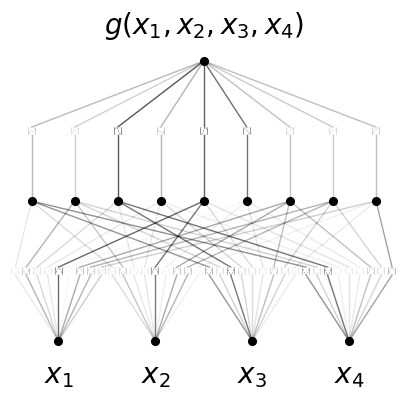

In [15]:
model.plot(beta=3, in_vars=['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars=['$g(x_1,x_2,x_3,x_4)$'])

Questo è un modo per rappresentare la funzione $g$, tuttavia vista la complessità della funzione è possibile utilizzare una deep layer KAN per approssiamre la suddetta funzione.

Si può quindi ipotizzare di partire da una deep layer KAN avente architettura $[4,4,2,1]$, che però, mediante pruning, vedremo che può essere semplificata in una deep KAN avente struttura $[4,2,1,1]$, utilizzando le magnitudini di regolarizzazione e di entropia $\lambda_1=0,001$ e $\lambda_2=10$.

In [16]:
model = KAN(width=[4,4,2,1], grid=3, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=10.0);

train loss: 2.58e-02 | test loss: 2.38e-02 | reg: 2.96e+01 : 100%|██| 20/20 [00:11<00:00,  1.75it/s]


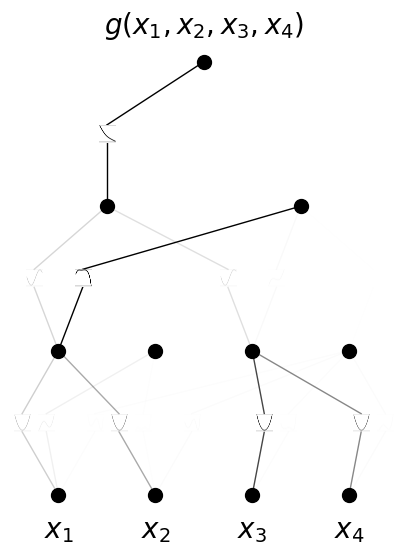

In [17]:
model.plot(beta=3, in_vars=['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars=['$g(x_1,x_2,x_3,x_4)$'])

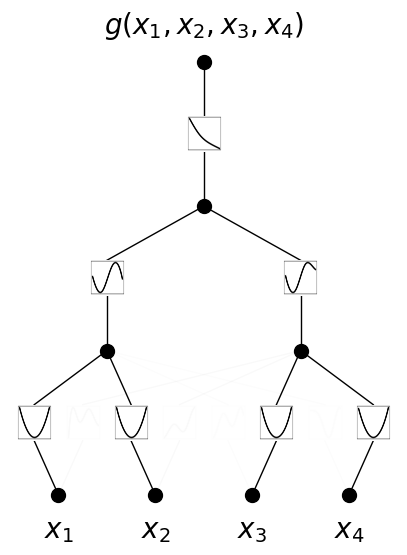

In [18]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot(beta=100, in_vars=['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars=['$g(x_1,x_2,x_3,x_4)$'])

Effettuando il pruning della deep layer KAN originale, abbaimo determinato che una buona parametrizzazione della funzione $g(x_1,x_2,x_3,x_4)$ si ottiene anche con una KAN avente struttura $[4,2,1,1]$, e difatti notiamo che le funzioni di attivazioni che si ottengono allenando la suddetta KAN sembrerebbero proprio quelle che compaiono in $g$:

- $\phi_{0,1,1}(x) = \phi_{0,1,2}(x) = \phi_{0,2,3}(x) = \phi_{0,2,4}(x) = x^2$
- $\phi_{1,1,1}(x) = \phi_{1,1,2}(x) = -\sin(\pi x)$
- $\phi_{2,1,1}(x) = e^{-x/2}$

Da cui di fatto
\begin{equation}
g(\textbf{x})=\phi_{2,1,1}\bigg(\phi_{1,1,1}\Big(\phi_{0,1,1}(x_1)+\phi_{0,1,2}(x_2)\Big)+\phi_{1,1,2}\Big(\phi_{0,2,3}(x_3)+\phi_{0,2,4}(x_4)\Big)\bigg)=\exp\Big(\frac{1}{2}\big(\sin(\pi(x_1^2+x_2^2))+\sin(\pi(x_3^2+x_4^2))\big)\Big)
\end{equation}

Fittiamo quindi i parametri affini delle funzioni di attivazione della KAN semplificata, verificando se la funzione da fittare venga effettivamente riconosciuta.

Facciamo ciò inizializzando fin da subito la KAN con architettura $[4,2,1,1]$, e allenandola sul dataset iniziale.

In [19]:
model = KAN(width=[4,2,1,1], grid=5, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=50);

train loss: 2.91e-03 | test loss: 2.81e-03 | reg: 7.71e+00 : 100%|██| 50/50 [00:16<00:00,  3.10it/s]


In [20]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
formula

fixing (0,0,0) with tan, r2=0.5015383362770081
fixing (0,0,1) with x^2, r2=0.9999986290931702
fixing (0,1,0) with exp, r2=0.7294201850891113
fixing (0,1,1) with x^2, r2=0.9999984502792358
fixing (0,2,0) with x^2, r2=0.9999986886978149
fixing (0,2,1) with tan, r2=0.4770941436290741
fixing (0,3,0) with x^2, r2=0.9999991059303284
fixing (0,3,1) with x^2, r2=0.747008740901947
fixing (1,0,0) with sin, r2=0.999984085559845
fixing (1,1,0) with sin, r2=0.9999781250953674
fixing (2,0,0) with exp, r2=0.9999998807907104


1.0*exp(-0.5*sin(3.14*x_1**2 + 3.14*x_2**2 + 3.14) + 0.5*sin(3.14*x_3**2 + 3.14*x_4**2 - 6.28))

La funzione da fittare è stata riconosciuta, in quanto $\sin(\pi x+\pi)=-\sin(\pi x)$ e $\sin(\pi x-2\pi)=\sin(\pi x)$.

---

Ora possiamo riproporre l'analisi precedente, attraverso le MLP di diversa profondità e larghezza, utilizzando in questo caso sia la KAN standard che permette di rappresentare $g$, sia la deep layer KAN.

In [21]:
# Definisco l'input e le epoche
input_size = training_data.shape[1]
num_epochs = 1000

Alleno i modelli MLP con due hidden layer.

In [22]:
set_seed(42)

mlp_parameters_d1 = []
mlp_test_loss_d1 = []

hidden_layers = 2
hidden_size = 8
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d1.append(final_test_loss)
mlp_parameters_d1.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 2
hidden_size = 16
mlp = MLP1(input_size, hidden_layers, hidden_size)
# num_params = hidden_layers * hidden_size * hidden_size
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d1.append(final_test_loss)
mlp_parameters_d1.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 2
hidden_size = 32
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d1.append(final_test_loss)
mlp_parameters_d1.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 2
hidden_size = 64
mlp = MLP1(input_size, hidden_layers, hidden_size)
# num_params = hidden_layers * hidden_size * hidden_size
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d1.append(final_test_loss)
mlp_parameters_d1.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 2
hidden_size = 100
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d1.append(final_test_loss)
mlp_parameters_d1.append(num_params)
print(f"Loss function di test MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

Loss function di test di MLP(2,8): 0.5387
Loss function di test di MLP(2,16): 0.4990
Loss function di test di MLP(2,32): 0.4509
Loss function di test di MLP(2,64): 0.3595
Loss function di test MLP(2,100): 0.2333


Alleno i modelli con tre hidden layer.

In [23]:
set_seed(42)

mlp_parameters_d2 = []
mlp_test_loss_d2 = []

hidden_layers = 3
hidden_size = 8
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d2.append(final_test_loss)
mlp_parameters_d2.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 3
hidden_size = 16
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d2.append(final_test_loss)
mlp_parameters_d2.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 3
hidden_size = 32
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d2.append(final_test_loss)
mlp_parameters_d2.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 3
hidden_size = 64
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampa la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d2.append(final_test_loss)
mlp_parameters_d2.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 3
hidden_size = 100
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d2.append(final_test_loss)
mlp_parameters_d2.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

Loss function di test di MLP(3,8): 0.5065
Loss function di test di MLP(3,16): 0.4403
Loss function di test di MLP(3,32): 0.2426
Loss function di test di MLP(3,64): 0.1571
Loss function di test di MLP(3,100): 0.1153


Alleno i modelli con quattro hidden layer.

In [24]:
set_seed(42)

mlp_parameters_d3 = []
mlp_test_loss_d3 = []

hidden_layers = 4
hidden_size = 8
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d3.append(final_test_loss)
mlp_parameters_d3.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 4
hidden_size = 16
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d3.append(final_test_loss)
mlp_parameters_d3.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 4
hidden_size = 32
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d3.append(final_test_loss)
mlp_parameters_d3.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 4
hidden_size = 64
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d3.append(final_test_loss)
mlp_parameters_d3.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 4
hidden_size = 100
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d3.append(final_test_loss)
mlp_parameters_d3.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

Loss function di test di MLP(4,8): 0.4470
Loss function di test di MLP(4,16): 0.3675
Loss function di test di MLP(4,32): 0.1742
Loss function di test di MLP(4,64): 0.1127
Loss function di test di MLP(4,100): 0.0964


Alleno i modelli con cinque hidden layer.

In [25]:
set_seed(42)

mlp_parameters_d4 = []
mlp_test_loss_d4 = []

hidden_layers = 5
hidden_size = 8
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d4.append(final_test_loss)
mlp_parameters_d4.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 5
hidden_size = 16
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d4.append(final_test_loss)
mlp_parameters_d4.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 5
hidden_size = 32
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d4.append(final_test_loss)
mlp_parameters_d4.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 5
hidden_size = 64
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d4.append(final_test_loss)
mlp_parameters_d4.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

###########################################################################

hidden_layers = 5
hidden_size = 100
mlp = MLP1(input_size, hidden_layers, hidden_size)
num_params = count_parameters(mlp)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Array in cui salvo le loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    output = mlp(training_data)
    loss = criterion(output, training_label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    mlp.eval()
    with torch.no_grad():
        val_output = mlp(test_data)
        val_loss = criterion(val_output, test_label)
        val_losses.append(val_loss.item())

# Stampo la perdita di test finale utilizzando l'array val_losses
final_test_loss = np.sqrt(val_losses[-1])
mlp_test_loss_d4.append(final_test_loss)
mlp_parameters_d4.append(num_params)
print(f"Loss function di test di MLP({int(hidden_layers)},{int(hidden_size)}): {final_test_loss:.4f}")

Loss function di test di MLP(5,8): 0.4075
Loss function di test di MLP(5,16): 0.2708
Loss function di test di MLP(5,32): 0.1541
Loss function di test di MLP(5,64): 0.1071
Loss function di test di MLP(5,100): 0.0996


Alleno ora il modello determinato dalla KAN standard con architettura $[4,9,1]$ che rappresenta la funzione $g$, aumentando man mano i parametri aumentando i grid $G$.

In [26]:
grids = [3,5,10,15,20,25]

kan_parameters = []
kan_test_loss = []

model = KAN(width=[4,9,1], grid=3, k=3, seed=0)

for i in range(len(grids)):
    model = KAN(width=[4,9,1], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
    kan_parameters.append(grids[i] * (4*9+9*1))
    kan_test_loss.append(results['test_loss'][-1].item())

train loss: 2.50e-02 | test loss: 2.47e-02 | reg: 2.03e+01 : 100%|██| 50/50 [00:38<00:00,  1.28it/s]
train loss: 1.46e-02 | test loss: 1.51e-02 | reg: 2.01e+01 : 100%|██| 50/50 [00:42<00:00,  1.17it/s]
train loss: 4.75e-03 | test loss: 6.32e-03 | reg: 1.91e+01 : 100%|██| 50/50 [00:53<00:00,  1.07s/it]
train loss: 3.20e-03 | test loss: 5.38e-03 | reg: 1.91e+01 : 100%|██| 50/50 [01:04<00:00,  1.29s/it]
train loss: 2.62e-03 | test loss: 5.94e-03 | reg: 1.93e+01 : 100%|██| 50/50 [01:15<00:00,  1.50s/it]
train loss: 2.18e-03 | test loss: 8.09e-03 | reg: 1.90e+01 : 100%|██| 50/50 [01:25<00:00,  1.70s/it]


Possiamo ora plottare le curve di apprendimento delle MLP aventi diverse profondità e quella del modello KAN che è stata soggetta al pruning, allenata con diversi valori del grid $G$.

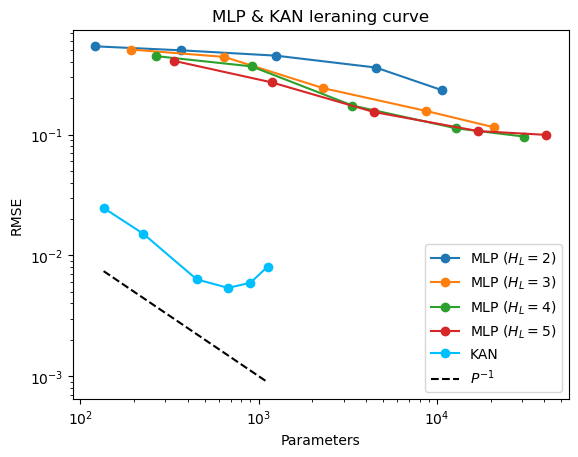

In [28]:
x = np.array(kan_parameters, dtype=float)
y = x**(-1)

plt.figure()
plt.plot(mlp_parameters_d1, mlp_test_loss_d1, marker='o', label='MLP ($H_L=2$)')
plt.plot(mlp_parameters_d2, mlp_test_loss_d2, marker='o', label='MLP ($H_L=3$)')
plt.plot(mlp_parameters_d3, mlp_test_loss_d3, marker='o', label='MLP ($H_L=4$)')
plt.plot(mlp_parameters_d4, mlp_test_loss_d4, marker='o', label='MLP ($H_L=5$)')
plt.plot(kan_parameters, kan_test_loss, marker='o', color='deepskyblue', label='KAN')
plt.plot(x, y, color='black', ls='--', label='$P^{-1}$')
plt.xlabel('Parameters')
plt.ylabel('RMSE')
plt.title('MLP & KAN leraning curve')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Questo grafico mostra come, proprio come nel caso precedente, la curva d'apprendimento della KAN risulta avere una pendenza molto più pronunciata di quella delle diverse MLP, che in questo caso risultano essere molto meno efficienti rispetto al caso precedente, vista la funzione molto complessa.

Anche in questo caso, la RMSE della KAN risulta di circa due ordini di grandezza minore rispetto a quella delle MLP, a parità di numero di parametri. Osserviamo inoltre che la curva d'apprendimento della KAN sembrerebbe scalare come $P^{-1}$.

Osserviamo inoltre la presenza di una situazione di overfitting per $G>10$, per cui la curva di apprendimento della KAN si appiattisce, per poi assumere una pendenza positiva, seppur rimanendo al di sotto delle curve dei modelli MLP.

---

Dunque paragoniamo le curve di apprendimento delle MLP con quella della KAN più semplice che approssima la funzione $g$, avente architettura $[4,2,1,1]$, determinata dal pruning effettuato precedentemente. Alleniamo quindi tale KAN, aumentandone man mano i parametri, aumentando i grid $G$.

In [29]:
grids = [3,5,10,15,20,30,40]

kan_parameters_1 = []
kan_test_loss_1 = []

model = KAN(width=[4,2,1,1], grid=3, k=3, seed=0)

for i in range(len(grids)):
    model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
    kan_parameters_1.append(grids[i] * (4*2+2*1+1*1))
    kan_test_loss_1.append(results['test_loss'][-1].item())

train loss: 5.21e-03 | test loss: 5.20e-03 | reg: 8.86e+00 : 100%|██| 50/50 [00:15<00:00,  3.30it/s]
train loss: 1.70e-03 | test loss: 1.74e-03 | reg: 8.97e+00 : 100%|██| 50/50 [00:16<00:00,  3.08it/s]
train loss: 1.43e-04 | test loss: 1.59e-04 | reg: 8.88e+00 : 100%|██| 50/50 [00:17<00:00,  2.78it/s]
train loss: 3.30e-05 | test loss: 3.55e-05 | reg: 8.88e+00 : 100%|██| 50/50 [00:13<00:00,  3.71it/s]
train loss: 1.60e-05 | test loss: 1.67e-05 | reg: 8.88e+00 : 100%|██| 50/50 [00:14<00:00,  3.54it/s]
train loss: 7.66e-06 | test loss: 5.18e-06 | reg: 8.88e+00 : 100%|██| 50/50 [00:18<00:00,  2.75it/s]
train loss: 5.61e-06 | test loss: 6.05e-06 | reg: 8.88e+00 : 100%|██| 50/50 [00:19<00:00,  2.54it/s]


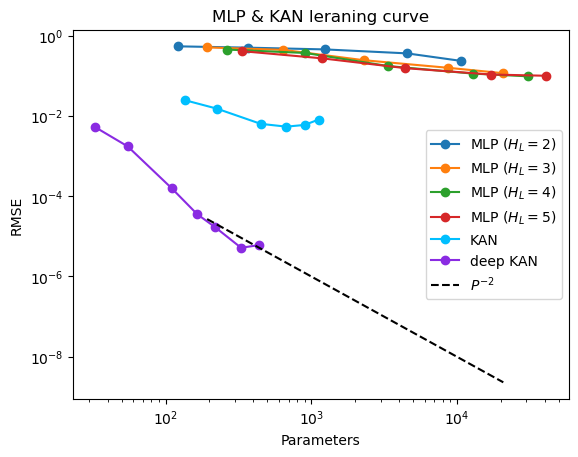

In [30]:
x = np.array(mlp_parameters_d2, dtype=float)
y = x**(-2)

plt.figure()
plt.plot(mlp_parameters_d1, mlp_test_loss_d1, marker='o', label='MLP ($H_L=2$)')
plt.plot(mlp_parameters_d2, mlp_test_loss_d2, marker='o', label='MLP ($H_L=3$)')
plt.plot(mlp_parameters_d3, mlp_test_loss_d3, marker='o', label='MLP ($H_L=4$)')
plt.plot(mlp_parameters_d4, mlp_test_loss_d4, marker='o', label='MLP ($H_L=5$)')
plt.plot(kan_parameters, kan_test_loss, marker='o', color='deepskyblue', label='KAN')
plt.plot(kan_parameters_1, kan_test_loss_1, marker='o', color='blueviolet', label='deep KAN')
plt.plot(x, y, color='black', ls='--', label='$P^{-2}$')
plt.xlabel('Parameters')
plt.ylabel('RMSE')
plt.title('MLP & KAN leraning curve')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Il grafico mostra come, utilizzando una deep layer KAN su cui è stato effettuato un pruning, si ottiene un'accuratezza nei risultati addirittura maggiore rispetto ad una KAN standard, anche se la funzione da fittare in esame è regolare, a parità di numero di parametri. Si osserva inoltre che, a differenza della curva di apprendimento della KAN standard, quella della deep layer KAN decresce come $P^{-2}$, quindi più rapidamente.

Osserviamo inoltre che anche nel caso della deep layer KAN, si ha una situazione di overfitting, ma in questo per un numero di grid tali che $G>30$. Si osserva una situazione di overfitting per un numero di grid maggiore, rispetto a quello della KAN standard, poichè la deep KAN semplificata, a parità di grid $G$, ha un numero di parametri minore rispetto a quella standard.